In [265]:
import matplotlib.pyplot as plt  # matplotlib for some plotting
import numpy as np  # numeric python functions
import pandas as pd  # need this to load our data from the csv files

from pyconturb import gen_turb, gen_spat_grid, TimeConstraint  # generate turbulence, useful helper
from pyconturb.sig_models import iec_sig  # IEC 61400-1 turbulence std dev
from pyconturb.spectral_models import kaimal_spectrum  # Kaimal spectrum
from pyconturb.wind_profiles import constant_profile, power_profile  # wind-speed profile functions

from _nb_utils import plot_slice
import h5py

## Constrained Turbulence ##
copied from [PyConTurb example](https://pyconturb.pages.windenergy.dtu.dk/pyconturb/notebooks/3_constr_time_series.html)

### Step 1: generate dataframe of measurement data ###

In [266]:
# sonic position
x_sonic1 = 0.0
y_sonic1 = 0.0
z_sonic1 = 2.23 # m above ground

sonic_spat_df = gen_spat_grid(y_sonic1, z_sonic1)  # if `comps` not passed in, assumes all 3 components are wanted
sonic_spat_df.head()  # look at the first few rows

,u_p0,v_p0,w_p0
k,0.00,1.00,2.00
x,0.00,0.00,0.00
y,0.00,0.00,0.00
z,2.23,2.23,2.23


In [267]:
# sonic_data_fn = 'sonic1_halfsecond.csv'
# sonic_data_fn = 'sonic1_20s.csv'
sonic_data_fn = 'sonic1_10min.csv'

tf_sonic1 = 600.0 # 20.0 # 0.5 #3.0 # s # 10 min = 10*60.0 s
dt_sonic1 = 1/20.0 # s
t_sonic1 = np.arange(0.0, tf_sonic1, dt_sonic1)
print(len(t_sonic1))

raw_data = pd.read_csv(sonic_data_fn, header=None)
raw_data = raw_data.rename(columns={0:'u_p0', 1:'v_p0', 2:'w_p0'})
for col in raw_data.filter(regex='u_', axis=1).columns:
    raw_data[col] = -1.0*raw_data[col] # to make it positive from the west
raw_data['index'] = t_sonic1
sonic_data = raw_data.set_index('index')
sonic_data

12000


,u_p0,v_p0,w_p0
index,,,
0.00,10.81890,0.654560,0.309693
0.05,9.27594,-0.150742,0.728396
0.10,9.60593,0.083863,0.848804
0.15,10.00270,-0.042294,-0.183993
0.20,10.90920,-0.007411,-1.310410
...,...,...,...
599.75,17.93440,2.365070,-1.808460
599.80,17.98580,2.394570,-1.745460
599.85,17.57440,2.398210,-1.750300


In [228]:
sonic_df = pd.concat([sonic_spat_df, sonic_data], axis=0)
sonic_df

,u_p0,v_p0,w_p0
k,0.0000,1.00000,2.000000
x,0.0000,0.00000,0.000000
y,0.0000,0.00000,0.000000
z,2.2300,2.23000,2.230000
0.0,10.8189,0.65456,0.309693
...,...,...,...
599.75,17.9344,2.36507,-1.808460
599.8,17.9858,2.39457,-1.745460
599.85,17.5744,2.39821,-1.750300
599.9,13.7994,2.09018,-0.803251


In [229]:
sonic_df.to_csv('generated_'+sonic_data_fn)

### Step 2: read in csv of measurement data ###

In [230]:
con_tc = TimeConstraint(pd.read_csv('generated_'+sonic_data_fn, index_col=0))  # load data from csv directly into tc
con_tc.index = con_tc.index.map(lambda x: float(x) if (x not in 'kxyz') else x)  # index cleaning
con_tc.iloc[:7, :]  # look at the first 7 rows

,u_p0,v_p0,w_p0
k,0.00000,1.000000,2.000000
x,0.00000,0.000000,0.000000
y,0.00000,0.000000,0.000000
z,2.23000,2.230000,2.230000
0.0,10.81890,0.654560,0.309693
0.05,9.27594,-0.150742,0.728396
0.1,9.60593,0.083863,0.848804


10.457779474999999


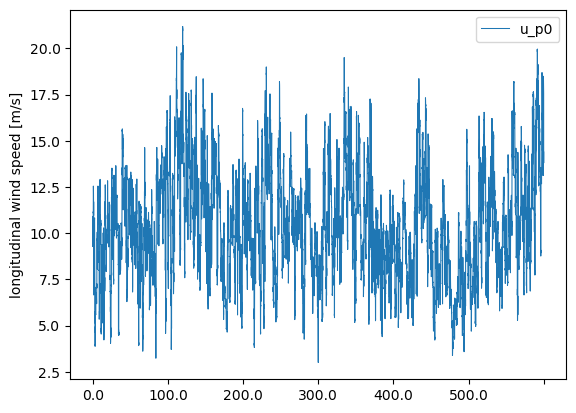

In [231]:
time_df = con_tc.get_time()
ax = time_df.filter(regex='u_', axis=1).plot(lw=0.75)  # subselect long. wind component
ax.set_ylabel('longitudinal wind speed [m/s]');
[print(x) for x in time_df.filter(regex='u_', axis=1).mean()];  # print mean values
u_mean_sonic1 = time_df.filter(regex='u_', axis=1).mean()

### Step 3: generate constrained turbulence box ###

In [232]:
# define spatial information
# y = np.linspace(-5, 5, 7) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
# z = np.linspace(0.5, 10.5, 13) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)

# to match ethan's example
ny = 41
nz = 20
y = np.linspace(-10.0, 10.0, ny) #11) #22)  # 11 lateral points from -50 to 50 (center @ 0)
z = np.linspace(0.00001, 10.5, nz) #13) # 26)  # 13 vertical points from 40 to 160 (center @ 100)

spat_df = gen_spat_grid(y, z)  # if `comps` not passed in, assumes all 3 components are wanted
spat_df.head()  # look at the first few rows

,u_p0,v_p0,w_p0,u_p1,v_p1,w_p1,u_p2,v_p2,w_p2,u_p3,...,w_p816,u_p817,v_p817,w_p817,u_p818,v_p818,w_p818,u_p819,v_p819,w_p819
k,0.00000,1.00000,2.00000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000,...,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.0,1.0,2.0
x,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
y,-10.00000,-10.00000,-10.00000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
z,0.00001,0.00001,0.00001,0.552641,0.552641,0.552641,1.105272,1.105272,1.105272,1.657903,...,8.842107,9.394738,9.394738,9.394738,9.947369,9.947369,9.947369,10.5,10.5,10.5


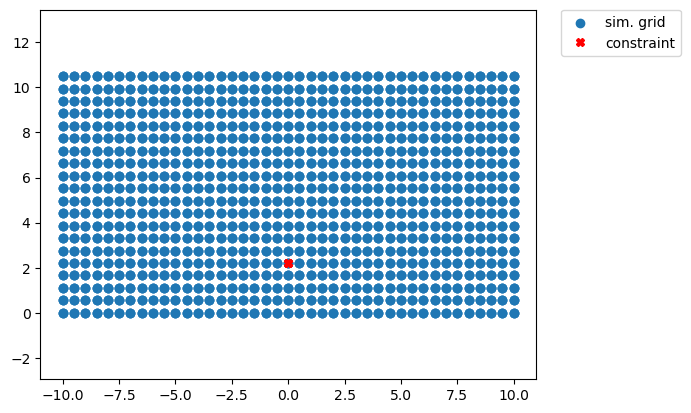

In [233]:
# visualization of simulation grid and constraining point(s)   
plt.scatter(spat_df.loc['y'], spat_df.loc['z'], label='sim. grid')
plt.plot(con_tc.iloc[2, :6], con_tc.iloc[3, :6], 'rX', label='constraint')
plt.axis('equal'); plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [234]:
# powerlaw_prof = power_profile(spat_df, u_ref=u_mean_sonic1.values[0], z_ref=2.23, alpha=0.2)
# powerlaw_prof

In [235]:
# define paramters for turbulence generation technique
# this example uses the default IEC 61400-1 Ed. 3 (Kaimal Spectrum with Exponential Coherence)
# instead of interpolating from the data

# kwargs = {'u_ref': u_mean_sonic1.values[0], 'turb_class': 'B', 'z_hub': 2.23,  # necessary keyword arguments for IEC turbulence
#           'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
# interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints

kwargs = {'u_ref': 20.5, 'turb_class': 'B', 'z_hub': 10,  # necessary keyword arguments for IEC turbulence
          'T': con_tc.get_T(), 'nt': con_tc.get_time().index.size}  # simulation length (s) and time step (s)
interp_data = 'none' # 'all'  # use the default IEC 61400-1 profile instead of interpolating from contstraints


# generate turbulence
sim_turb_df = gen_turb(spat_df, con_tc=con_tc, interp_data=interp_data, **kwargs)

In [236]:
# save to csv file
sim_turb_df.to_csv('constrained_turb_'+sonic_data_fn)

measured mean wind speed =  10.457779474999999
simulated mean wind speed =  9.7679810244841


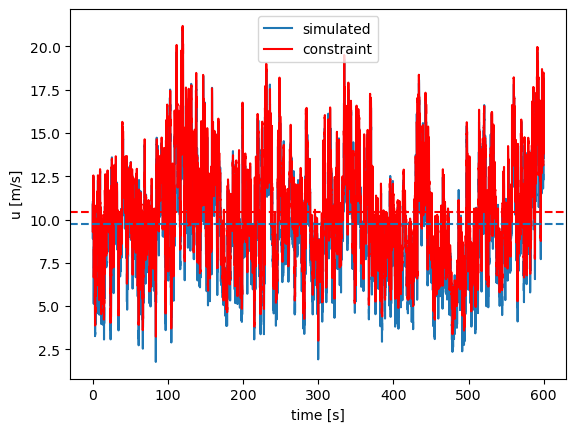

In [237]:
# sanity check - should be similar
# find the points close to where we want to look
yloc, zloc = 0, 2.23  # location we want to compare
isim = np.argmin((spat_df.loc['y'].values - yloc)**2+(spat_df.loc['z'].values - zloc)**2)
icon = np.argmin((con_tc.loc['y'].values - yloc)**2+(con_tc.loc['z'].values - zloc)**2)

# t, usim, ucon = sim_turb_df.index, sim_turb_df.iloc[:, isim], con_tc.get_time().iloc[:, icon]
t = sim_turb_df.index
usim = sim_turb_df.iloc[:, isim]
ucon = con_tc.get_time().iloc[:, icon]

# plot the time series
plt.plot(t, usim, label='simulated')
plt.plot(t, ucon, 'r', label='constraint')
plt.axhline(sim_turb_df.iloc[:, isim].mean(), t[0], t[-1], linestyle='--', color='C0')
plt.axhline(con_tc.get_time().iloc[:, icon].mean(), t[0], t[-1], linestyle='--', color='r')
plt.xlabel('time [s]')
plt.ylabel('u [m/s]')
plt.legend();

print('measured mean wind speed = ', con_tc.get_time().iloc[:, icon].mean())
print('simulated mean wind speed = ', sim_turb_df.iloc[:, isim].mean())

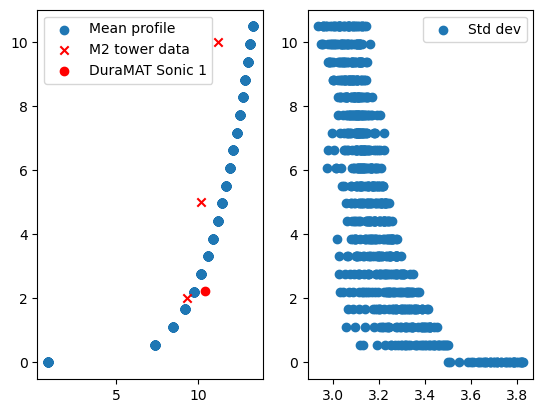

In [238]:
stats = sim_turb_df.filter(regex='u_', axis=1).describe().loc[['mean', 'std']]
# plot
plt.clf(); plt.subplot(1, 2, 1);
plt.scatter(stats.loc['mean'], spat_df.filter(regex='u_').loc['z'], label='Mean profile')
plt.scatter(m2_us, m2_zs, color='r', marker='x', label='M2 tower data')
plt.scatter(con_tc.get_time().iloc[:, icon].mean(), 2.23, color='r', marker='o', label='DuraMAT Sonic 1')
# plt.axhline(spat_df['u_p404'].z, stats.loc['mean'].min(), stats.loc['mean'].max(), linestyle='--', color='k')
# plt.axhline(2.23, stats.loc['mean'].min(), stats.loc['mean'].max(), linestyle='--', color='r')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.scatter(stats.loc['std'], spat_df.filter(regex='u_').loc['z'], label='Std dev')
plt.legend();

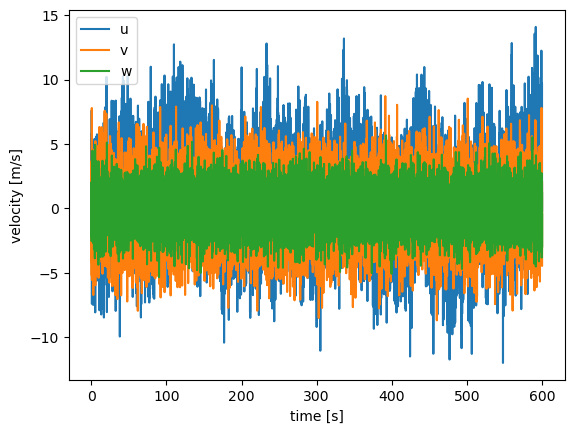

In [239]:
plt.plot(sim_turb_df.u_p0, label='u')
plt.plot(sim_turb_df.v_p0, label='v')
plt.plot(sim_turb_df.w_p0, label='w')
plt.ylabel('velocity [m/s]')
plt.xlabel('time [s]')
plt.legend()

In [240]:
# reshape to 3D array
data = {}
data['u'] = sim_turb_df.filter(regex='u').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))
data['v'] = sim_turb_df.filter(regex='v').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))
data['w'] = sim_turb_df.filter(regex='w').values.reshape(len(sim_turb_df),y.size,z.size).transpose((0, 2, 1))

Text(0.5, 1.0, 'last timestep')

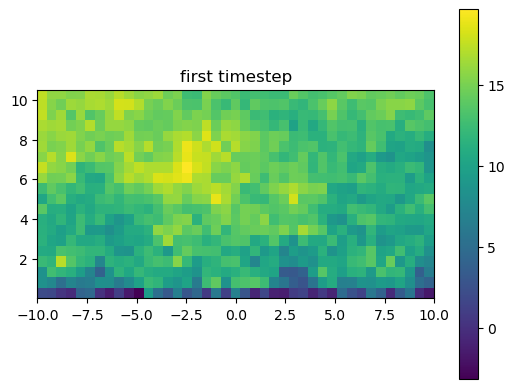

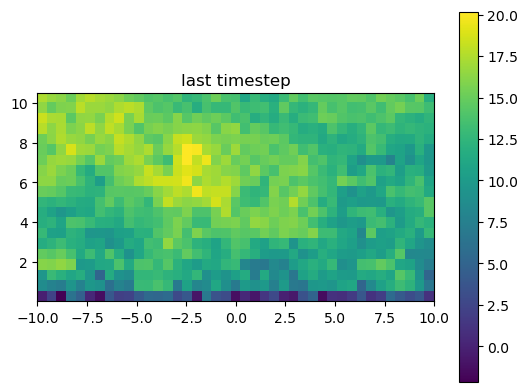

In [241]:
fig, ax = plt.subplots()
plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='none')  # image smoothing
plt.colorbar()
plt.title('first timestep')

fig, ax = plt.subplots()
plt.imshow(data['u'][-1,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='none')  # image smoothing
plt.colorbar()
plt.title('last timestep')


### Step 4: Save generated turbulence as .h5 file for input to PVade ###

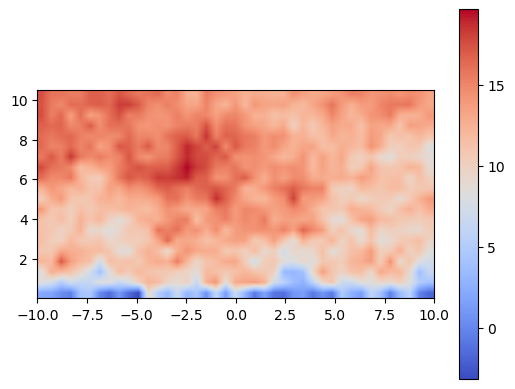

In [242]:
fig, ax = plt.subplots()
plt.imshow(data['u'][0,:,:],  # imshow requires nz-ny slice
            origin='lower',  # smallest y-z in lower left, not upper left
            extent=[y[0], y[-1], z[0], z[-1]],  # lateral and vertical limits
            interpolation='bilinear',
            cmap='coolwarm')  # image smoothing
plt.colorbar()

In [245]:
h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
h5_filename

'pct_turb_sonic1_10min.h5'

In [260]:
con_tc.get_time().index.values.astype(float)

array([0.0000e+00, 5.0000e-02, 1.0000e-01, ..., 5.9985e+02, 5.9990e+02,
       5.9995e+02])

time_index (12000,) float32
u (12000, 20, 41) float32
v (12000, 20, 41) float32
w (12000, 20, 41) float32
y_coordinates (41,) float32
z_coordinates (20,) float32


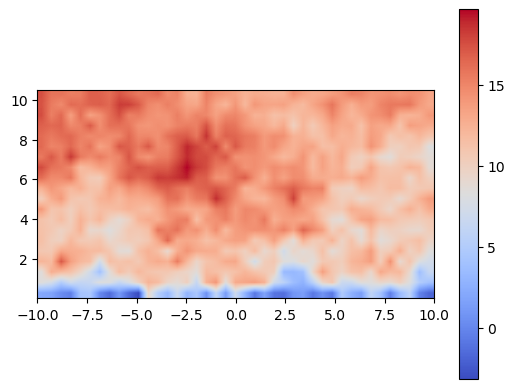

In [261]:
h5_filename = 'pct_turb_'+sonic_data_fn[:-4]+'.h5'
t_steps = con_tc.get_time().index.size
time = con_tc.get_time().index.values.astype(float)

with h5py.File(h5_filename, "w") as fp:
    fp.create_dataset("time_index", shape=(t_steps,))
    fp["time_index"][:] = time
    
    fp.create_dataset("y_coordinates", shape=(ny,))
    fp["y_coordinates"][:] = y
        
    fp.create_dataset("z_coordinates", shape=(nz,))
    fp["z_coordinates"][:] = z
        
    fp.create_dataset("u", shape=(t_steps, nz, ny))
    fp["u"][:] = data['u'][:]
    
    fp.create_dataset("v", shape=(t_steps, nz, ny))
    fp["v"][:] = data['v'][:]
    
    fp.create_dataset("w", shape=(t_steps, nz, ny))
    fp["w"][:] = data['w'][:]

with h5py.File(h5_filename, "r") as fp:
    for key, val in fp.items():
        print(key, val.shape, val.dtype)
        
    y_fp = fp["y_coordinates"][:]
    z_fp = fp["z_coordinates"][:]

    fig, ax = plt.subplots()
    plt.imshow(fp["u"][0, :, :],  # imshow requires nz-ny slice
                origin='lower',  # smallest y-z in lower left, not upper left
                extent=[y_fp[0], y_fp[-1], z_fp[0], z_fp[-1]],  # lateral and vertical limits
                interpolation='bilinear',
                cmap='coolwarm')  # image smoothing
    plt.colorbar()

### Step 6: Compare metrics of simulated turbulence to measurement data ###

In [273]:
sonic_data.filter(regex='u_', axis=1).values.squeeze()

array([10.8189 ,  9.27594,  9.60593, ..., 17.5744 , 13.7994 , 14.395  ])

In [279]:
nPxxf_U_corr[1]

np.float64(0.0018443325162982899)

TypeError: object of type 'numpy.float64' has no len()

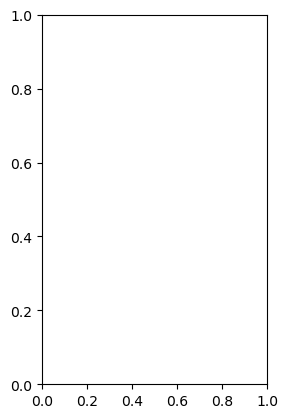

In [277]:
# spectra
from scipy.signal import welch
from numpy import hanning
import math

heights = [2.23] 
fs = 20
overlap = 0
nblock = len(sonic_data)
win = np.hamming(math.floor(nblock/10))

U_corr = pd.Series(sonic_data.filter(regex='u_', axis=1).values.squeeze())
U_mean = U_corr.mean()
u_std = U_corr.std()
# do I need to detrend this?

f_U_corr, Pxxf_U_corr = welch(U_corr.dropna(), fs, window=win, noverlap=overlap, nfft=nblock, detrend='constant', return_onesided=True)
nf_U_corr = f_U_corr*heights[0]/abs(U_mean)
nPxxf_U_corr = (f_U_corr*Pxxf_U_corr)/u_std**2

plt.figure()
plt.subplot(1,2,1)
plt.loglog(abs(nf_U_corr[0:len(nPxxf_U_corr[1])]), nPxxf_U_corr[1])  
# plt.loglog(abs(nf_U_corr[0:len(nPxxf_m od_U_corr[1])]), nPxxf_mod_U_corr[1])            
plt.legend(loc='lower left',fontsize=8)
plt.xlabel("$fz/U$")
plt.ylabel("$fS_u/\sigma_u$")
plt.title('inflow (west) streamwise u spectra')
plt.xlim(10e-3, 10e-1)
plt.ylim(10e-3, 10e-1)
plt.show()

12000